# Part 1: Preparing SVI data 

# SVI data  
Dowonload the ESRI Geodatabase data in census tract level using the link >>> [Data Source](https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html)

[Documentation](https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/pdf/SVI-2022-Documentation-H.pdf)

## SVI variables used in caculation are starred

### Theme 1: Socioeconomic Status
F_POV150 = Flag - the percentage of persons below 150% poverty is in the 90th percentile (1 = yes, 0 =no)*

F_UNEMP Flag - the percentage of civilian unemployed is in the 90th percentile (1 = yes, 0 = no)*

F_HBURD Flag - the percentage of housing costburdened occupied housing units is in the 90th percentile (1 = yes, 0 = no)*

F_UNINSUR Flag - the percentage of uninsured is in the 90th percentile (1 = yes, 0 = no)*

F_THEME1 Sum of flags for Socioeconomic Status theme 

### Theme 2: Household Characteristics
F_AGE65 Flag - the percentage of persons aged 65 and older is in the 90th percentile (1 = yes, 0 = no)*

F_AGE17 Flag - the percentage of persons aged 17 and younger is in the 90th percentile (1 = yes, 0 = no)*

F_DISABL Flag - the percentage of persons with a disability is in the 90th percentile (1 = yes, 0 = no)*

F_LIMENG Flag - the percentage those with limited English is in the 90th percentile (1 = yes, 0 = no)*

F_THEME2 Sum of flags for Household Characteristics

### Theme 4: Housing Type & Transportation 
F_MUNIT Flag - the percentage of households in multiunit housing is in the 90th percentile (1 = yes, 0 = no)*

F_MOBILE Flag - the percentage of mobile homes is in the 90th percentile (1 = yes, 0 = no)* 

F_CROWD Flag - the percentage of crowded households is in the 90th percentile (1 = yes, 0 = no)*

F_NOVEH Flag - the percentage of households with no vehicles is in the 90th percentile (1 = yes, 0 = no)*

F_GROUPQ Flag - the percentage of persons in group quarters is in the 90th percentile (1 = yes, 0= no)*

F_THEME4 Sum of flags for Housing Type/ Transportation theme 4 SVI F_MUNIT + F_MOBILE + F_CROWD + F_NOVEH + F_GROUPQ

Total Themes: F_TOTAL Sum of flags for the four themes SVI F_THEME1 + F_THEME2 + F_THEME3 + F_THEME4 





#### Step 1: Load the ESRI Geodatabase and Clip the Data

In [5]:
%pip install folium 

Defaulting to user installation because normal site-packages is not writeable
  Using cached folium-0.17.0-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached branca-0.7.2-py3-none-any.whl.metadata (1.5 kB)
Using cached folium-0.17.0-py2.py3-none-any.whl (108 kB)
Using cached branca-0.7.2-py3-none-any.whl (25 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: C:\Users\Lyn\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import rasterio
from rasterio.features import rasterize
from rasterio.plot import show
#import folium
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib.colors import Normalize
from rasterio.transform import from_bounds
#from osgeo import gdal, ogr, osr
import os

In [2]:

# Load the ESRI Geodatabase
#gdb_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N/Texas/SVI2022_TEXAS_tract.gdb'
#gdf = gpd.read_file(gdb_path)

# Load the shapefile for your area
area_shapefile = r'C:/Users/Lyn/Documents/ArcGIS/CUAHSI SI 2024/svi/svi_2016_clipped.shp' #AOI
area_gdf = gpd.read_file(area_shapefile)


# Reproject the shapefile to match the CRS of the ESRI Geodatabase
area_gdf = area_gdf.to_crs(gdf.crs)

# Clip the geodatabase data to your area
clipped_gdf = gpd.clip(gdf, area_gdf)


# Save the clipped data for further processing
clipped_gdf.to_file(r'D:/Hesham/CUAHSI/Geospatial/Jupyter N2/clipped_data.shp')


C:\Users\hhp1483\AppData\Local\Temp\ipykernel_10768\2221481982.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_gdf.to_file(r'D:/Hesham/CUAHSI/Geospatial/Jupyter N2/clipped_data.shp')


In [4]:
#start here if you already have a clipped shapefile
path = r'C:/Users/Lyn/Documents/ArcGIS/CUAHSI SI 2024/svi/svi_2016_clipped.shp' 
clipped_gdf = gpd.read_file(path)


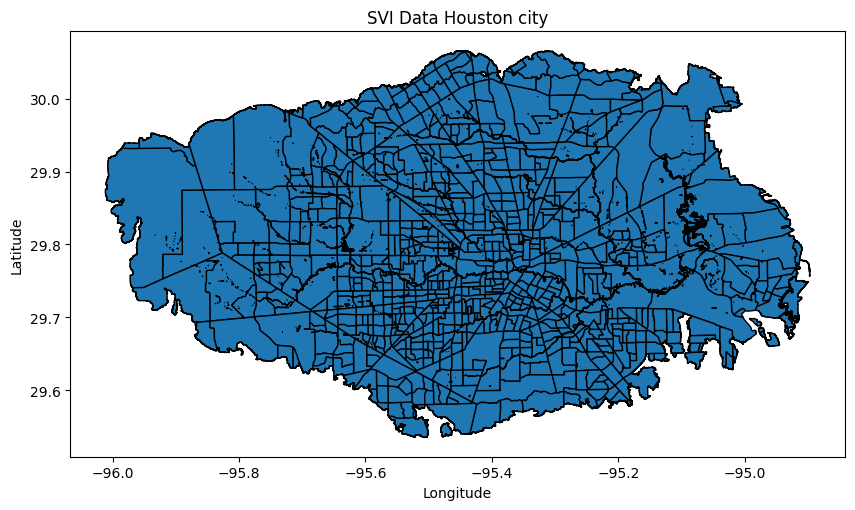

In [6]:
# Load the clipped data
clipped_gdf = gpd.read_file(path)

# Plot the clipped data
fig, ax = plt.subplots(figsize=(10, 10))
clipped_gdf.plot(ax=ax, edgecolor='k')

# Optionally, add the area boundary for reference
#area_gdf = gpd.read_file(r'D:/Hesham/CUAHSI/Geospatial/Jupyter N/AOI/HUC8_Houston4326.shp')
#area_gdf.boundary.plot(ax=ax, color='red')

plt.title('SVI Data Houston city')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


#### Step 2: Filter and Clean the Data

In [8]:
# Identify the columns starting with 'F_'
flag_columns = [col for col in clipped_gdf.columns if col.startswith('F_')]

# Keep geospatial columns (geometry) and flag columns
columns_to_keep = ['geometry'] + flag_columns
clipped_gdf = clipped_gdf[columns_to_keep]

# Function to fill -999 values with the average of neighboring values
def fill_missing_values(gdf, columns):
    for col in columns:
        missing_indices = gdf[gdf[col] == -999].index
        for idx in missing_indices:
            neighbors = gdf[gdf.geometry.touches(gdf.loc[idx, 'geometry'])]
            if not neighbors.empty:
                gdf.at[idx, col] = int(np.round(neighbors[col].replace(-999, np.nan).mean()))
    return gdf

# Fill missing values
clipped_gdf = fill_missing_values(clipped_gdf, flag_columns)

# Save the cleaned data
clipped_gdf.to_file(r'C:/Users/Lyn\Documents/Programming/Python_codes/Impact_Map_Forecasting/Input_files/svi_cleaned.shp')


#### Step 3: Calculate the Final SVI

In [9]:
# Load the cleaned data
#clipped_gdf = gpd.read_file(r'D:/Hesham/CUAHSI/Geospatial/Jupyter N2/cleaned_data.shp')

# Select specific variables for SVI calculation
selected_variables = ['F_POV150', 'F_UNEMP', 'F_HBURD', 'F_UNINSUR', 'F_AGE65', 'F_AGE17', 'F_DISABL', 'F_LIMENG', 'F_MUNIT', 'F_MOBILE', 'F_CROWD', 'F_NOVEH', 'F_GROUPQ']
clipped_gdf['SVI'] = clipped_gdf[selected_variables].sum(axis=1)

# Remove all columns except 'geometry' and 'SVI'
clipped_gdf = clipped_gdf[['geometry', 'SVI']]

# Visualize the SVI with a legend
fig, ax = plt.subplots(figsize=(10, 10))

# Number of classes for visualization
num_classes = 5
cmap = plt.cm.viridis
norm = colors.BoundaryNorm(np.linspace(clipped_gdf['SVI'].min(), clipped_gdf['SVI'].max(), num_classes + 1), cmap.N)

# Plot the data
clipped_gdf.plot(column='SVI', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False, norm=norm)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.026, pad=0.01)
cbar.set_label('SVI')

plt.title('Social Vulnerability Index (SVI)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Save the SVI data
clipped_gdf.to_file(r'C:/Users/Lyn\Documents/Programming/Python_codes/Impact_Map_Forecasting/Input_files/svi_cleaned.shp')


KeyError: "['F_POV150', 'F_HBURD', 'F_UNINSUR'] not in index"

In [10]:
%pip install osgeo

Defaulting to user installation because normal site-packages is not writeable
  Using cached osgeo-0.0.1.tar.gz (1.2 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build osgeo
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for osgeo (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [49 lines of output]
      running bdist_wheel
      running build
      installing to build\bdist.win-amd64\wheel
      running install
      Traceback (most recent call last):
        File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
          main()
        File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\site-packages\

#### Step 4: Build a Raster Map
Convert the final SVI data into a raster map with specified cell size and number of classes

In [1]:
import os
import geopandas as gpd
from osgeo import gdal, ogr, osr

# Set the working directory
os.chdir(r'C:/Users/Lyn/Documents/Programming/Python_codes/Impact_Map_Forecasting/Texas_example')

# Read the shapefile using GeoPandas
shapefile = gpd.read_file(r'D:/Hesham/CUAHSI/Geospatial/Jupyter N2/svi_data.shp')

# Open the shapefile using OGR
input_shp = ogr.Open(r'D:/Hesham/CUAHSI/Geospatial/Jupyter N2/svi_data.shp')
source_layer = input_shp.GetLayer()
defn = source_layer.GetLayerDefn()

# Extract column names
column_names = []
for n in range(defn.GetFieldCount()):
    fdefn = defn.GetFieldDefn(n)
    column_names.append(fdefn.GetName())

# Define output raster location and pixel size
output_raster_location = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/svi_raster.tif'
pixel_size = 0.0001

# Get extent of the source layer
xmin, xmax, ymin, ymax = source_layer.GetExtent()

# Calculate resolution
x_res = int(round((xmax - xmin) / pixel_size))
y_res = int(round((ymax - ymin) / pixel_size))

# Create the target raster file
target_ds = gdal.GetDriverByName('GTiff').Create(output_raster_location, x_res, y_res, 1, gdal.GDT_Float32, ['COMPRESS=LZW'])
target_ds.SetGeoTransform((xmin, pixel_size, 0, ymax, 0, -pixel_size))

# Set projection
srs = osr.SpatialReference()
srs.ImportFromEPSG(4269)  # EPSG:4269 is NAD83
target_ds.SetProjection(srs.ExportToWkt())

# Get the raster band and set NoData value
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(-9999)
band.Fill(-9999)

# Rasterize the shapefile layer to the raster
gdal.RasterizeLayer(target_ds, [1], source_layer, options=['ALL_TOUCHED=TRUE', 'ATTRIBUTE=SVI'])

# Close the raster dataset
target_ds = None

print("Rasterization complete!")


ModuleNotFoundError: No module named 'osgeo'

##### Visualize the raster

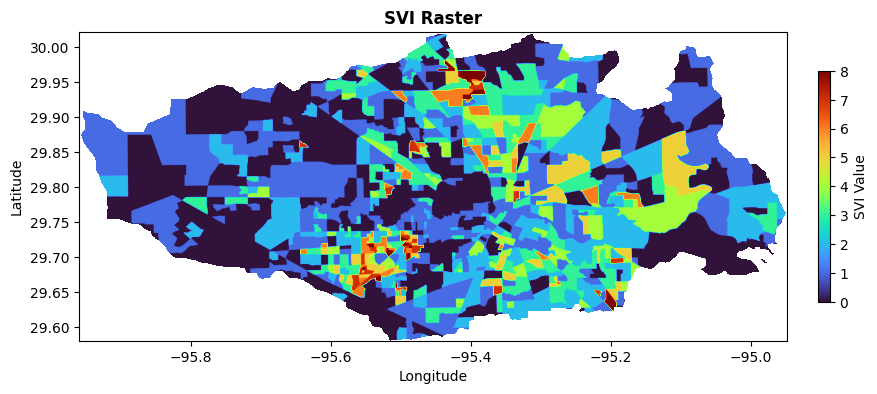

In [10]:
# Define the path to the raster file
raster_file = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/svi_raster.tif'

# Open the raster file
with rasterio.open(raster_file) as src:
    # Plot the raster
    fig, ax = plt.subplots(figsize=(10, 10))
    img = show(src, ax=ax, cmap='turbo', title='SVI Raster')
    
    # Set axis labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Add colorbar with size control
    cbar = plt.colorbar(img.get_images()[0], ax=ax, orientation='vertical', fraction=0.046, pad=0.04, shrink=0.3)
    cbar.set_label('SVI Value')

    # Show plot
    plt.show()

# Part 2: Caculate the Impact 

#### Step 1: read the svi raster and fim raster

In [ ]:
import rasterio

# Define the paths to the raster files
svi_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/svi_raster.tif'
fim_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/fim_raster.tif'

def check_raster_properties(raster_path):
    with rasterio.open(raster_path) as src:
        print(f"Properties of {raster_path}:")
        print(f" CRS: {src.crs}")
        print(f" Cell size: {src.res}")
        print(f" Width: {src.width}, Height: {src.height}")
        print(f" Bounds: {src.bounds}")
        print()

# Read and check properties of SVI raster
check_raster_properties(svi_raster_path)

# Read and check properties of FIM raster
check_raster_properties(fim_raster_path)


#### Step 2: Reproject and Resample SVI Raster
Skip this if they have smae projection and cell size

##### make sure that the svi map has the same crs and cell size of fim map

In [13]:
import os
from osgeo import gdal
import rasterio

# Define the paths to the raster files
svi_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/svi_raster.tif'
fim_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/fim_raster.tif'
aligned_svi_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/aligned_svi_raster.tif'

# Open the FIM raster to get the projection, geotransform, and size
fim_ds = gdal.Open(fim_raster_path)
if fim_ds is None:
    raise RuntimeError(f"Failed to open FIM raster {fim_raster_path}")

fim_proj = fim_ds.GetProjection()
fim_geotransform = fim_ds.GetGeoTransform()
fim_width = fim_ds.RasterXSize
fim_height = fim_ds.RasterYSize

print(f"FIM Raster Properties:\n CRS: {fim_proj}\n Geotransform: {fim_geotransform}\n Width: {fim_width}, Height: {fim_height}")

# Reproject and resample the SVI raster to match the FIM raster
warp_options = gdal.WarpOptions(
    format='GTiff',
    outputBounds=(fim_geotransform[0], fim_geotransform[3] + fim_height * fim_geotransform[5], fim_geotransform[0] + fim_width * fim_geotransform[1], fim_geotransform[3]),
    width=fim_width,
    height=fim_height,
    dstSRS=fim_proj,
    xRes=fim_geotransform[1],
    yRes=-fim_geotransform[5],
    resampleAlg=gdal.GRA_Bilinear,
    targetAlignedPixels=True
)

print("Warp options set.")

aligned_svi_raster = gdal.Warp(aligned_svi_raster_path, svi_raster_path, options=warp_options)
if aligned_svi_raster is None:
    raise RuntimeError(f"gdal.Warp failed to create {aligned_svi_raster_path}")

print("SVI raster has been reprojected and resampled to match the FIM raster.")

# Verify the properties of the aligned SVI raster
def check_raster_properties(raster_path):
    with rasterio.open(raster_path) as src:
        print(f"Properties of {raster_path}:")
        print(f" CRS: {src.crs}")
        print(f" Cell size: {src.res}")
        print(f" Width: {src.width}, Height: {src.height}")
        print(f" Bounds: {src.bounds}")
        print()

# Check properties of the aligned SVI raster
check_raster_properties(aligned_svi_raster_path)


FIM Raster Properties:
 CRS: PROJCS["NAD83 / Conus Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]
 Geotransform: (-1110.5905641159043, 10.0, 0.0, 776904.2824222166, 0.0, -10.0)
 Width: 10776, Height: 5899
Warp options set.
SVI raster has been reprojected and resampled to match the FIM raster.
Properties of D:/Hesham/CUAHSI/Geospatial/Jupyter N3/aligned_svi_raster.tif:
 CRS: EPSG:5070
 Cell size: (10.0, 10

SVI Raster Statistics:
 Min: 0.0
 Max: 8.0
 Mean: 1.5050808191299438
 Std Dev: 1.6493839025497437
FIM Raster Statistics:
 Min: 0.0
 Max: 14.70419979095459
 Mean: 0.06381913274526596
 Std Dev: 0.44431403279304504


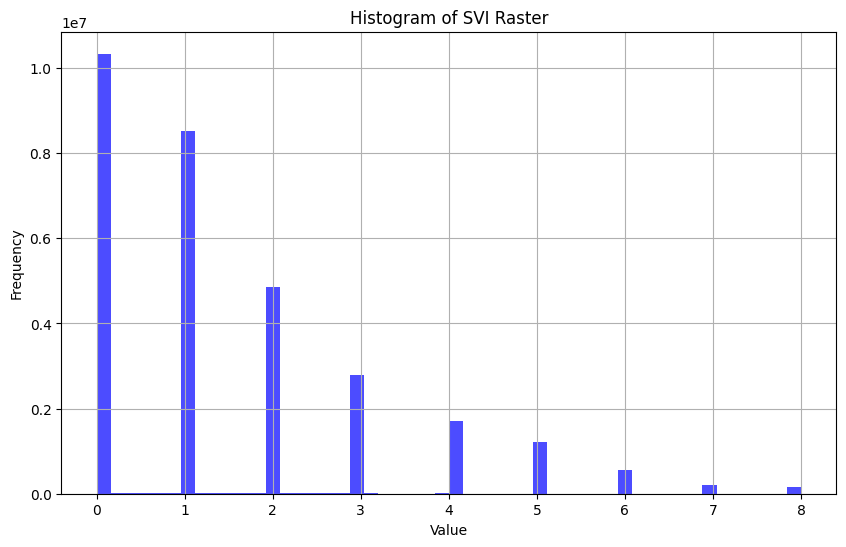

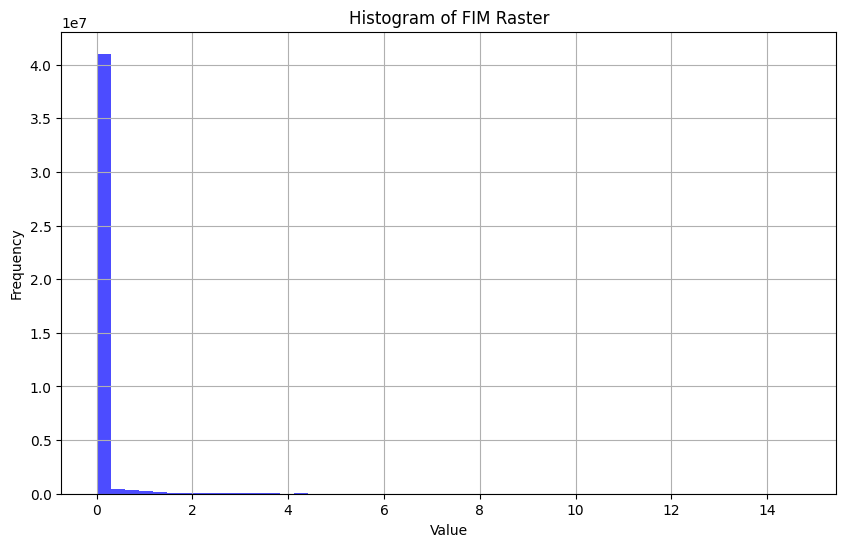

In [14]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define the paths to the raster files
svi_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/aligned_svi_raster.tif'
fim_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/fim_raster.tif'

def compute_statistics(raster_path):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        nodata = src.nodata
        if nodata is not None:
            data = data[data != nodata]  # Remove NoData values
        min_val = np.min(data)
        max_val = np.max(data)
        mean_val = np.mean(data)
        std_val = np.std(data)
        
        return min_val, max_val, mean_val, std_val

def plot_histogram(raster_path, title):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        nodata = src.nodata
        if nodata is not None:
            data = data[data != nodata]  # Remove NoData values
        plt.figure(figsize=(10, 6))
        plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
        plt.title(f"Histogram of {title}")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

# Compute statistics for SVI raster
svi_min, svi_max, svi_mean, svi_std = compute_statistics(svi_raster_path)
print(f"SVI Raster Statistics:\n Min: {svi_min}\n Max: {svi_max}\n Mean: {svi_mean}\n Std Dev: {svi_std}")

# Compute statistics for FIM raster
fim_min, fim_max, fim_mean, fim_std = compute_statistics(fim_raster_path)
print(f"FIM Raster Statistics:\n Min: {fim_min}\n Max: {fim_max}\n Mean: {fim_mean}\n Std Dev: {fim_std}")

# Plot histograms
plot_histogram(svi_raster_path, "SVI Raster")
plot_histogram(fim_raster_path, "FIM Raster")


#### Step 3: Multiply the two rasters (reclassified FIM and SVI) to produce the FVI (impact map)

##### 1- reclassify FIM

In [12]:
import numpy as np
import rasterio

def reclassify_fim(input_path, output_path):
    with rasterio.open(input_path) as src:
        data = src.read(1).astype('float32')
        nodata = src.nodata

        if nodata is not None:
            data = np.ma.masked_equal(data, nodata)
        
        # Reclassify the FIM data
        reclassified_data = np.digitize(data, bins=[0.01, 0.5, 1, 2], right=True)
        reclassified_data = np.where(data == 0, 0, reclassified_data)  # Class 0 for non-flooded areas

        # Preserve nodata values
        reclassified_data = np.ma.filled(reclassified_data, nodata)

        meta = src.meta
        meta.update(dtype='float32', nodata=-9999)

        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(reclassified_data.astype('float32'), 1)

fim_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/fim_raster.tif'
reclassified_fim_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N4/reclassified_fim_raster2.tif'

reclassify_fim(fim_raster_path, reclassified_fim_path)
print("Reclassified FIM raster has been saved.")


Reclassified FIM raster has been saved.


##### 2- create impact map

In [13]:
def multiply_rasters(svi_path, fim_path, output_path):
    with rasterio.open(svi_path) as svi_src:
        svi_data = svi_src.read(1).astype('float32')
        svi_nodata = svi_src.nodata

    with rasterio.open(fim_path) as fim_src:
        fim_data = fim_src.read(1).astype('float32')
        fim_meta = fim_src.meta
        fim_nodata = fim_src.nodata

    if svi_data.shape != fim_data.shape:
        raise ValueError("The rasters do not have the same shape.")

    # Ensure that nodata values are handled correctly
    nodata_value = -9999
    svi_data = np.where(svi_data == svi_nodata, np.nan, svi_data)
    fim_data = np.where(fim_data == fim_nodata, np.nan, fim_data)

    # Multiply the rasters to get the impact map, ignoring NaN values
    impact_data = np.where(np.isnan(svi_data) | np.isnan(fim_data), nodata_value, svi_data * fim_data)

    # Save the impact map to a new raster file
    impact_meta = fim_meta.copy()
    impact_meta.update({
        'dtype': 'float32',
        'nodata': nodata_value
    })

    with rasterio.open(output_path, 'w', **impact_meta) as impact_dst:
        impact_dst.write(impact_data.astype('float32'), 1)

svi_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/aligned_svi_raster.tif'
reclassified_fim_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N4/reclassified_fim_raster2.tif'
impact_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N4/impact_rastertest.tif'

multiply_rasters(svi_raster_path, reclassified_fim_path, impact_raster_path)
print("Impact map has been saved.")


Impact map has been saved.


###### 3- Mask zeros in the impact maps

Masked impact map has been saved.


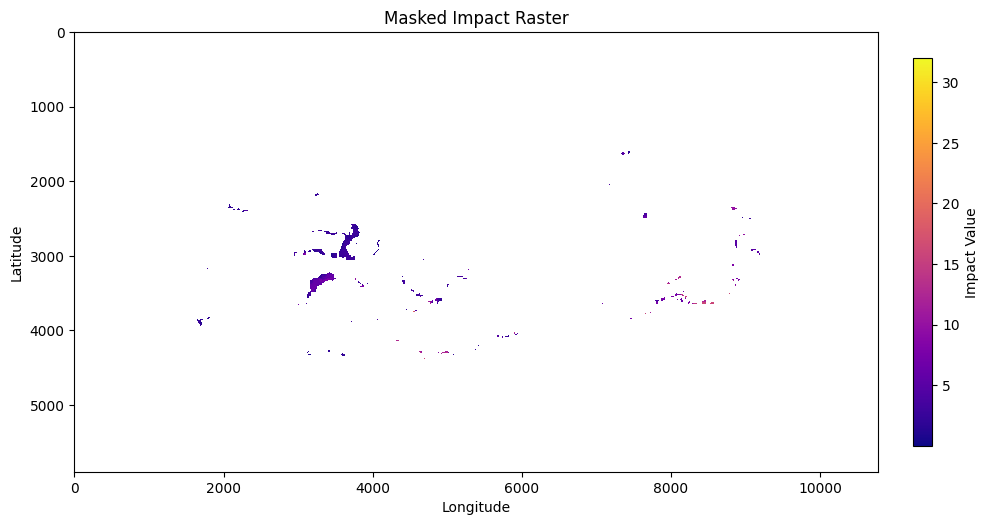

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def mask_zeros(input_path, output_path):
    with rasterio.open(input_path) as src:
        data = src.read(1).astype('float32')
        nodata = src.nodata

        masked_data = np.where(data == 0, nodata, data)

        meta = src.meta
        meta.update(dtype='float32', nodata=nodata)

        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(masked_data.astype('float32'), 1)

impact_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N4/impact_rastertest.tif'
masked_impact_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N4/masked_impact_raster.tif'

mask_zeros(impact_raster_path, masked_impact_raster_path)
print("Masked impact map has been saved.")

def plot_raster(ax, raster_path, title):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        nodata = src.nodata
        if nodata is not None:
            data = np.ma.masked_equal(data, nodata)  # Mask NoData values

        img = ax.imshow(data, cmap='plasma', norm=Normalize(vmin=data.min(), vmax=data.max()))
        ax.set_title(title)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        return img

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the masked impact raster
img = plot_raster(ax, masked_impact_raster_path, "Masked Impact Raster")

# Add colorbars with size control
cbar = fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04, shrink=0.4)
cbar.set_label('Impact Value')

# Adjust layout
plt.tight_layout()
plt.show()


##### 4- reclassify the impact map

Data range: 1.28449137264397e-05 to 32.0
Classified data range: -9999.0 to 4.0
Classified impact map has been saved.


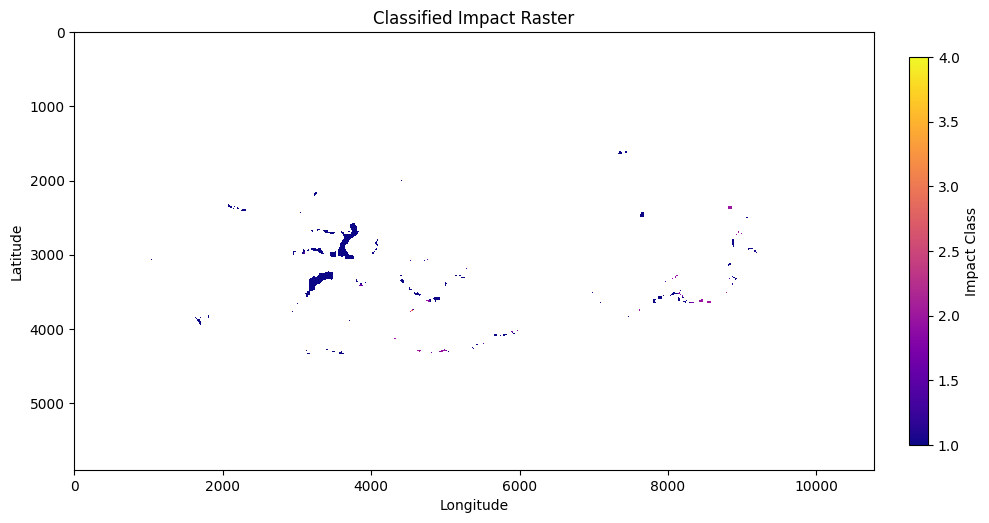

In [28]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def classify_raster(input_path, output_path):
    with rasterio.open(input_path) as src:
        data = src.read(1).astype('float32')
        nodata = src.nodata

        # Mask nodata values
        data_masked = np.ma.masked_equal(data, nodata)
        
        # Identify the range of the data excluding nodata values
        min_value = data_masked.min()
        max_value = data_masked.max()
        print(f"Data range: {min_value} to {max_value}")

        # Classify the data into 4 equal intervals
        bins = np.linspace(min_value, max_value, 5)  # 5 bins will create 4 intervals
        classified_data = np.digitize(data_masked, bins, right=True)  # Digitize creates 1 to 4 classes

        # Convert the classified_data mask to nodata values
        classified_data[data_masked.mask] = nodata

        print(f"Classified data range: {np.min(classified_data)} to {np.max(classified_data)}")

        meta = src.meta
        meta.update(dtype='float32', nodata=nodata)

        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(classified_data.astype('float32'), 1)

masked_impact_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N4/masked_impact_raster.tif'
classified_impact_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N4/classified_impact_raster.tif'

classify_raster(masked_impact_raster_path, classified_impact_raster_path)
print("Classified impact map has been saved.")

def plot_raster(ax, raster_path, title):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        nodata = src.nodata
        if nodata is not None:
            data = np.ma.masked_equal(data, nodata)  # Mask NoData values

        img = ax.imshow(data, cmap='plasma', norm=Normalize(vmin=1, vmax=4))  # Set vmin and vmax to match class values
        ax.set_title(title)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        return img

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the classified impact raster
img = plot_raster(ax, classified_impact_raster_path, "Classified Impact Raster")

# Add colorbars with size control
cbar = fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04, shrink=0.4)
cbar.set_label('Impact Class')

# Adjust layout
plt.tight_layout()
plt.show()


##### visualization

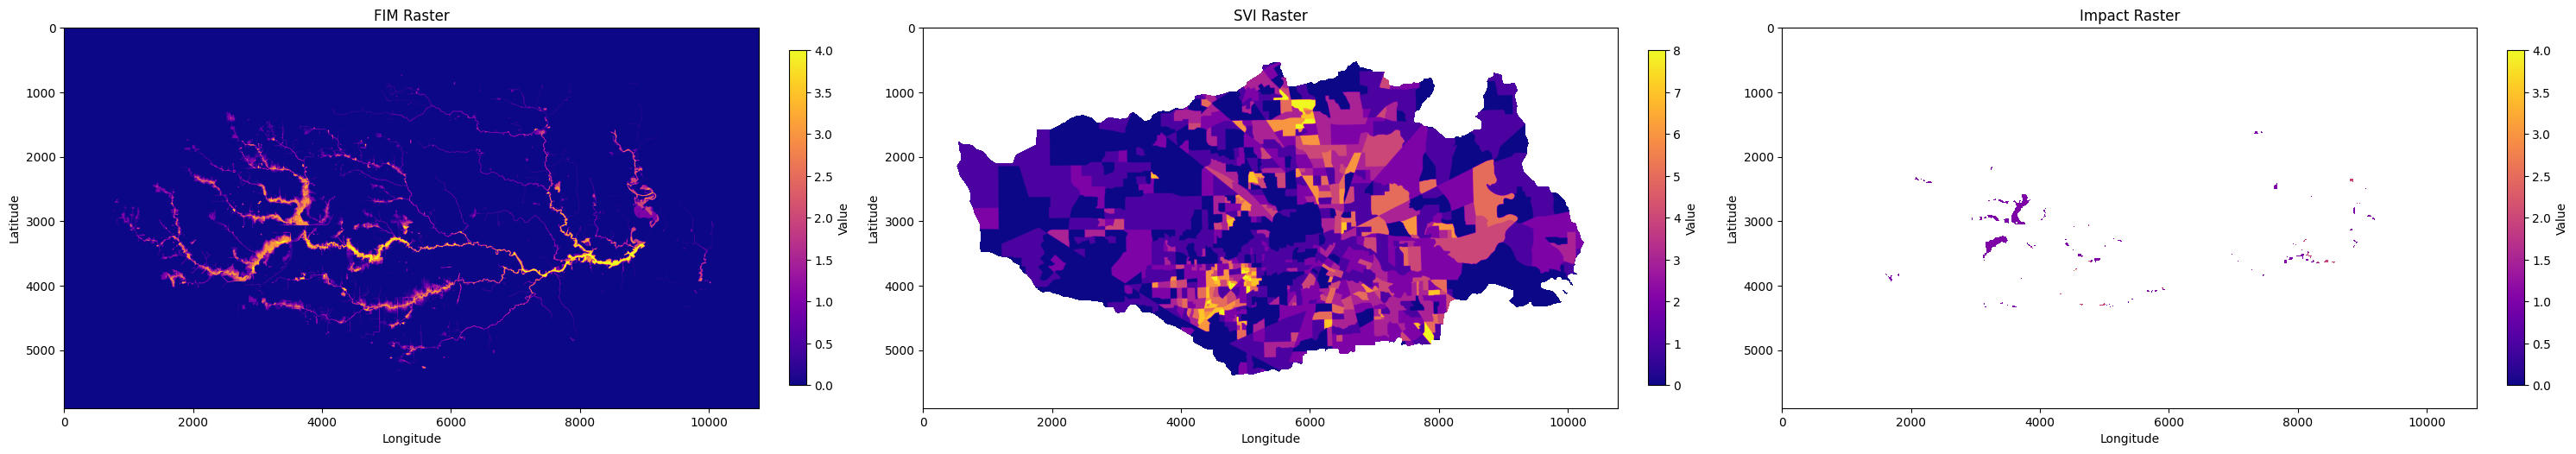

In [30]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Paths to the raster files
fim_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N4/reclassified_fim_raster2.tif'
svi_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N3/aligned_svi_raster.tif'
impact_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N4/classified_impact_raster1.tif'

def plot_raster(ax, raster_path, title):
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        nodata = src.nodata
        if nodata is not None:
            data = np.ma.masked_equal(data, nodata)  # Mask NoData values

        img = ax.imshow(data, cmap='plasma', norm=Normalize(vmin=data.min(), vmax=data.max()))
        ax.set_title(title)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        return img

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Plot the FIM raster
img1 = plot_raster(axes[0], fim_raster_path, "FIM Raster")

# Plot the SVI raster
img2 = plot_raster(axes[1], svi_raster_path, "SVI Raster")

# Plot the impact raster
img3 = plot_raster(axes[2], impact_raster_path, "Impact Raster")

# Add colorbars with size control
cbar1 = fig.colorbar(img1, ax=axes[0], fraction=0.046, pad=0.04, shrink=0.4)
cbar1.set_label('Value')

cbar2 = fig.colorbar(img2, ax=axes[1], fraction=0.046, pad=0.04, shrink=0.4)
cbar2.set_label('Value')

cbar3 = fig.colorbar(img3, ax=axes[2], fraction=0.046, pad=0.04, shrink=0.4)
cbar3.set_label('Value')

# Adjust layout
plt.tight_layout()
plt.show()


#### Step 4: convert the impact raster map to shapefile 

In [31]:
from osgeo import gdal, ogr
import numpy as np


def raster_to_shapefile(raster_path, shapefile_path):
    # Open the reclassified raster
    src_ds = gdal.Open(raster_path)
    if src_ds is None:
        raise RuntimeError(f"Failed to open raster {raster_path}")
    
    # Get the raster band
    src_band = src_ds.GetRasterBand(1)
    nodata = src_band.GetNoDataValue()
    
    # Create the output shapefile
    driver = ogr.GetDriverByName('ESRI Shapefile')
    if driver is None:
        raise RuntimeError("ESRI Shapefile driver not available.")
    
    dst_ds = driver.CreateDataSource(shapefile_path)
    if dst_ds is None:
        raise RuntimeError(f"Failed to create shapefile {shapefile_path}")
    
    srs = ogr.osr.SpatialReference()
    srs.ImportFromWkt(src_ds.GetProjection())
    
    dst_layer = dst_ds.CreateLayer('impact', srs=srs, geom_type=ogr.wkbPolygon)
    if dst_layer is None:
        raise RuntimeError(f"Failed to create layer in shapefile {shapefile_path}")
    
    field_defn = ogr.FieldDefn('FIV_Class', ogr.OFTInteger)
    dst_layer.CreateField(field_defn)
    
    # Polygonize the raster, skipping NoData values
    gdal.Polygonize(src_band, src_band.GetMaskBand(), dst_layer, 0, options=["8CONNECTED=8"], callback=None)
    
    # Remove features with the NoData value
    dst_layer.SetAttributeFilter(f"FIV_Class = {int(nodata)}")
    for feature in dst_layer:
        dst_layer.DeleteFeature(feature.GetFID())
    dst_layer.SetAttributeFilter(None)
    
    # Close the datasets
    src_ds = None
    dst_ds = None

# Path to the reclassified impact raster file
reclassified_raster_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N4/classified_impact_raster1.tif'
shapefile_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N4/reclassified_impact_raster.shp'


# Convert the reclassified raster to a shapefile
raster_to_shapefile(reclassified_raster_path, shapefile_path)
print("Shapefile has been created.")


c:\Users\hhp1483\AppData\Local\anaconda3\envs\py310\lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Shapefile has been created.


#### add column to attribute table of FIV map to describe the severity of the vulnerability

In [33]:
from osgeo import ogr

def add_vulnerability_column(shapefile_path):
    # Open the shapefile
    driver = ogr.GetDriverByName('ESRI Shapefile')
    ds = driver.Open(shapefile_path, 1)  # Open in write mode
    if ds is None:
        raise RuntimeError(f"Failed to open shapefile {shapefile_path}")
    
    layer = ds.GetLayer()
    
    # Add new field for vulnerability levels
    vulnerability_field = ogr.FieldDefn('Vuln_Level', ogr.OFTString)
    vulnerability_field.SetWidth(32)
    layer.CreateField(vulnerability_field)
    
    # Define the vulnerability levels
    vulnerability_levels = {
        1: "Low Vulnerability",
        2: "Medium Vulnerability",
        3: "High Vulnerability",
        4: "Very High Vulnerability"    
    }
    
    # Update the new field based on FIV_Class
    for feature in layer:
        fiv_class = feature.GetField('FIV_Class')
        vulnerability_level = vulnerability_levels.get(fiv_class, "Unknown")
        feature.SetField('Vuln_Level', vulnerability_level)
        layer.SetFeature(feature)
    
    # Close the dataset
    ds = None
    print("Vulnerability level column has been added to the shapefile.")

# Path to the shapefile
shapefile_path = r'D:/Hesham/CUAHSI/Geospatial/Jupyter N4/reclassified_impact_raster.shp'

# Add the vulnerability level column
add_vulnerability_column(shapefile_path)


Vulnerability level column has been added to the shapefile.
